***
<div style="text-align:center">
     <h1 align="center">
         <i class="fas fa-calendar-day" aria-hidden="true">  Day 27 of #66daysofdata_NLP </i>
    </h1>      
</div>

<h2 style='text-align: center;'>
    <mark>Plagiarism detector app </mark>
</h2>

<h3 style='text-align: center;'>
    Preparing the data
</h3>


* ref: 
- [https://towardsdatascience.com](https://towardsdatascience.com/build-a-plagiarism-checker-using-machine-learning-6538110ce162)
* data set:
- [Kaggle: dataset of news articles ](https://www.kaggle.com/snapcrack/all-the-news) 
- Context:
    - The dataset consists of 143,000 news stories from 15 important publishers like: include the New York Times, Breitbart, CNN, Business Insider, the Atlantic, Fox News, Talking Points Memo, Buzzfeed News, and so on.
    - We're just utilizing the first `20,000` of 143,000 news stories from 15 prominent publishers in this dataset.
    
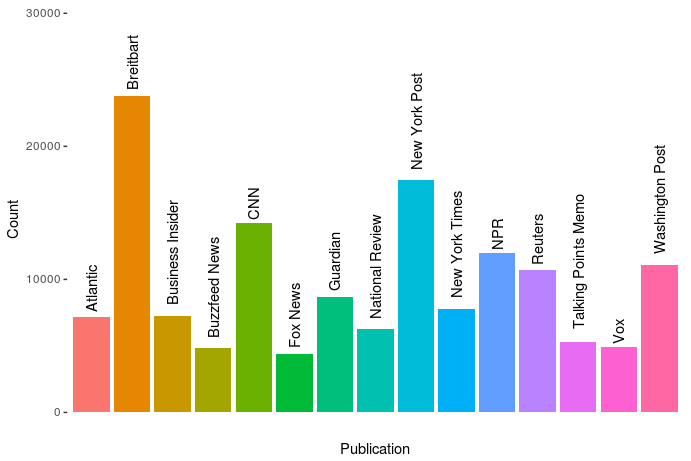


### Install required libraries


!pip install sentence-transformers
!pip install python-dotenv
!pip install flask
!pip install pinecone-client 
!pip install swifter

# Installing previous versions of PyTorch 
# CUDA 10.1
!conda install pytorch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2 cudatoolkit=10.1 -c pytorch -y

### load libraries

In [1]:
# Import everything that will be used
from flask import Flask, render_template, request, url_for
import json
import os
import pandas as pd
#import pinecone     # a similarity search service — to find possibly plagiarized content.
import re
import requests
from sentence_transformers import SentenceTransformer
from statistics import mean
import swifter

In [2]:
DATA_FILE = "articles.csv"
NROWS = 20000

## Loading dataset

In [3]:
df = pd.read_csv('../datasets/plagiarism_articles/' + DATA_FILE)
# Clean rows with nan text and drop all columns except text and category
with pd.option_context('max_colwidth',199):
    print('\nData Frame head:\n')
    display(df.head(2))
    print('\nSample article:\n')
    display(df.content[0][:500])


Data Frame head:



,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Health Care Suit,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have a new fear when it comes to their health care lawsuit against the Obama administration: They might win. The incoming Trump administration could c...
1,1,17284,Rift Between Officers and Residents as Killings Persist in South Bronx,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood dries and the votive candles burn out, people peer down from windows and see crime scenes gone cold: a band of yellow police tape blowing in the b..."



Sample article:



'WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could concei'

## Preparing data

In [4]:
data = df.copy()

# rename id column and remove unnecessary columns
data.rename(columns={"Unnamed: 0": "article_id"}, inplace = True)
data.drop(columns=['date'], inplace = True)

# combine the article title and content into a single field
data['content'] = data['content'].fillna('')
# split the text to sentences end with " . " or " ; "
data['content'] = data.content.swifter.apply(lambda x: ' '.join(re.split(r'(?<=[.:;])\s', x)))
data['title_and_content'] = data['title'] + ' ' + data['content']

data.head()


Pandas Apply:   0%|          | 0/19999 [00:00<?, ?it/s]

,article_id,id,title,publication,author,year,month,url,content,title_and_content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,House Republicans Fret About Winning Their Hea...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",Rift Between Officers and Residents as Killing...
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...","Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Music",New York Times,William McDonald,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...","Among Deaths in 2016, a Heavy Toll in Pop Musi..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",Kim Jong-un Says North Korea Is Preparing to T...


In [5]:
print(f"\nSample text:\n\n{data['title_and_content'][0][:300]} ...")


Sample text:

House Republicans Fret About Winning Their Health Care Suit WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branc ...


## Create a model

`Models of Average Word Embeddings` calculate the 'average word embedding for certain well-known word embedding approaches.'


* Model: `average_word_embeddings_komninos`

        This is a sentence-transformers model: It maps sentences & paragraphs to a 300 dimensional dense vector space and can be used for tasks like clustering or semantic search. 

In [6]:
model = SentenceTransformer('average_word_embeddings_komninos')

### Saving the pretrained model

In [7]:
model.save("../models/average_word_embeddings_komninos")

### Loading the pretrained model

In [8]:
offline_model = SentenceTransformer("../models/average_word_embeddings_komninos")

* apply sentence trasformer encoding on sample article

In [9]:
encoded_article = offline_model.encode(data['title_and_content'][0], show_progress_bar=False)
print(f"The encoded article vector shape is: {encoded_article.shape}")

The encoded article vector shape is: (300,)


### Create a vector embedding based on title and article content

In [10]:
encoded_articles = offline_model.encode(data['title_and_content'], show_progress_bar=True)
print(f"The encoded article vectors shape is: {encoded_articles.shape}")

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

The encoded article vectors shape is: (19999, 300)


In [11]:
data['article_vector'] =  pd.Series(encoded_articles.tolist())
print(f"""len of article_vectors column is: {len(data['article_vector'])} 
and len of each article vector is: {len(data['article_vector'][0])}""")

len of article_vectors column is: 19999 
and len of each article vector is: 300


***
<div style="text-align:center">
     <h1 align="center">
         <i class="fas fa-calendar-day" aria-hidden="true">  Day 28 of #66daysofdata_NLP </i>
    </h1>      
</div>

<h2 style='text-align: center;'>
    <mark>Plagiarism detector app </mark>
</h2>

<h3 style='text-align: center;'>
    Indexing the data
</h3>

#### pinecone:  A similarity search service — to find possibly plagiarized content

In [12]:
import pinecone

In [16]:
def initialize_pinecone():
    print('Starting initialization ...')
    PINECONE_API_KEY = "YOUR_API_KEY"
    env = 'us-west1-gcp'

    pinecone.init(api_key=PINECONE_API_KEY,environment=env)
    print('Initialization Done!')

def delete_existing_pinecone_index(permission=True):
    print("Check if PINECONE_INDEX_NAME is in pinecone.list_indexes")
    if permission:
        if PINECONE_INDEX_NAME in pinecone.list_indexes():
            pinecone.delete_index(PINECONE_INDEX_NAME)
            print('deleting done!')
        else:
            print('PINECONE_INDEX_NAME not in index list')
    else:
        print('Not permitted to delete the existing index!')

def create_pinecone_index(PINECONE_INDEX_NAME):
    print("create_pinecone_index ...")
    if PINECONE_INDEX_NAME not in pinecone.list_indexes():
        pinecone.create_index(name=PINECONE_INDEX_NAME, dimension=300, metric="cosine",replicas=1)
    else:
        print('The pinecone_index is already created!')
    pinecone_index = pinecone.Index(index_name=PINECONE_INDEX_NAME)
    print("create_pinecone_index Done!")
    return pinecone_index


In [17]:
PINECONE_INDEX_NAME = "plagiarism-tester"

# geting our API key from the .env file and using it to initialize Pinecone.
initialize_pinecone()
# Finds our pinecone instance for an index with the same name as the one we're using ("plagiarism-tester"). 
# If an existing index is found, we remove it. 
delete_existing_pinecone_index(permission=False)
# creating a new index using the name of our choice ("plagiarism-tester"), the proximity metric "cosine" and a single shard.
pinecone_index = create_pinecone_index(PINECONE_INDEX_NAME)

Starting initialization ...
Initialization Done!
Check if PINECONE_INDEX_NAME is in pinecone.list_indexes
Not permitted to delete the existing index!
create_pinecone_index ...
The pinecone_index is already created!
create_pinecone_index Done!


* Creating `vector embedding` for each article & inserting the vector embedding into the `Pinecon index`. 

In [18]:
pinecone.whoami()

WhoAmIResponse(username='67f53f8', user_label='quickstart', projectname='7669daf')

In [19]:
vector_count = int(pinecone_index.describe_index_stats()['namespaces']['']['vector_count'])

if vector_count != len(data['article_vector']):
    print('upsert the data!')
    
    import itertools

    def chunks(iterable, batch_size=300):
        it = iter(iterable)
        chunk = tuple(itertools.islice(it, batch_size))
        while chunk:
            yield chunk
            chunk = tuple(itertools.islice(it, batch_size))

    for batch in chunks(zip(data.id.astype(str), data.article_vector)):
        pinecone_index.upsert(vectors=batch)
    print('upserting data done! ')
    
else:
      print('Indexer is ready!')    
        

Indexer is ready!


In [20]:
titles_mapped       = dict(zip(data.id.astype(str), data.title))
publications_mapped = dict(zip(data.id.astype(str), data.publication))
publications_mapped = dict(zip(data.id.astype(str), data.publication))

## Evaluating our model and indexing engine with an example

In [21]:
originalContent = """Congressional Republicans have a new fear when it comes to their health care lawsuit 
                  against the Obama administration: They might win. 
                  The incoming Trump administration could choose to no longer defend the executive branc
                """
query_content = originalContent

query_vectors = [model.encode(str(query_content)).tolist()]

In [22]:
%%time
query_results = pinecone_index.query(queries=query_vectors, top_k=10)

pd.set_option('max_colwidth', -1)
for query, res in zip([query_content], query_results.results):
    print("\n\n Original query : " + str(query))
    print(f"\n Original title is:  '{'House Republicans Fret About Winning Their Health Care Suit'}'")
    print("\n Most similar titles based on pinecone vector search: \n")

    ids = [match.id for match in res.matches]
    scores = [match.score for match in res.matches]
    df_result = pd.DataFrame(
        {
            "id": ids,
            "title": [ titles_mapped[_id] for _id in ids ],            
            "publication": [ publications_mapped[_id] for _id in ids ],          
            "score": scores,
        }
    )
display(df_result)



 Original query : Congressional Republicans have a new fear when it comes to their health care lawsuit 
                  against the Obama administration: They might win. 
                  The incoming Trump administration could choose to no longer defend the executive branc
                

 Original title is:  'House Republicans Fret About Winning Their Health Care Suit'

 Most similar titles based on pinecone vector search: 



,id,title,publication,score
0,17283,House Republicans Fret About Winning Their Health Care Suit,New York Times,0.925263
1,17977,Trump Follows Obama’s Lead in Flexing Executive Muscle,New York Times,0.917132
2,18892,"Desperate for Presidential Leadership, Republicans Find Little",New York Times,0.916514
3,35726,Ted Cruz Endorses Donald Trump for President,Breitbart,0.915242
4,30260,No Deal on Health Care as Congress Goes into Recess,Breitbart,0.913738
5,36292,California Leaders to Lame Duck Obama: Save Us from Trump!,Breitbart,0.913384
6,18688,"With Coverage in Peril and Obama Gone, Health Law’s Critics Go Quiet",New York Times,0.909657
7,19264,G.O.P. Senators Suggest Changes for Health Care Bill Offered by House,New York Times,0.909075
8,19334,Trump and G.O.P. Work to Win Repeal of Obama’s Health Act,New York Times,0.908275
9,17349,Senate Republicans Open Fight Over Obama Health Law,New York Times,0.908189


CPU times: user 39.1 ms, sys: 0 ns, total: 39.1 ms
Wall time: 342 ms


***
<div style="text-align:center">
     <h1 align="center">
         <i class="fas fa-calendar-day" aria-hidden="true">  Day 29 of #66daysofdata_NLP </i>
    </h1>      
</div>

<h2 style='text-align: center;'>
    <mark>Plagiarism detector app </mark>
</h2>

<h3 style='text-align: center;'>
    Flask web app
</h3>

In [149]:
app = Flask(__name__)

In [150]:
def query_pinecone(originalContent):
    print("\n\n Original query : " + str(originalContent))
    query_content = str(originalContent)
    query_vectors = [model.encode(str(query_content)).tolist()]

    query_results = pinecone_index.query(queries=query_vectors, top_k=10)
    
    result = query_results['results'][0]
    ids = [match.id for match in result.matches]
    scores = [match.score for match in result.matches]
    
    results_list = []
    for id, score in zip(ids, scores):
        results_list.append({
                "id": id,
                "title": titles_mapped[id],
                "publication": publications_mapped[id],
                "score": score,
        })

    return json.dumps(results_list)

In [151]:
@app.route("/")
def index():
    return render_template("index.html")

@app.route("/api/search", methods=["POST", "GET"])
def search():
    if request.method == "POST":        
        json_dump = query_pinecone(request.form.get("originalContent", ""))
        return json_dump
    
    if request.method == "GET":
        return query_pinecone(request.args.get("originalContent", ""))
    return "Only GET and POST methods are allowed for this endpoint"

app.run(host='0.0.0.0',port=5100)